In [1]:
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


import json
import numpy as np
import pandas as pd

# Function to load and compute mean metrics from a JSON file for a specific case
def compute_mean_metrics(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    mean_metrics = {}
    metrics = set()  # Collect unique metrics across all videos
    
    # Gather all metrics
    for video_data in data.values():
        metrics.update(video_data.keys())
    
    for metric in metrics:
        values = [video_data[metric] for video_data in data.values() if video_data.get(metric) is not None]
        mean_metrics[metric] = float(np.mean(values)) if values else None
    
    return mean_metrics

# Paths to JSON files for different cases (adjust paths as needed)
case_paths = {
    "none": "/data/maryamsana_98/UniControl_Video_Interpolation/evaluations/gop8/uvg/none/all_videos_metrics.json",
    "sparse": "/data/maryamsana_98/UniControl_Video_Interpolation/evaluations/gop8/uvg/sparse/all_videos_metrics.json",
    "dense": "/data/maryamsana_98/UniControl_Video_Interpolation/evaluations/gop8/uvg/dense/all_videos_metrics.json"
}

# Compute average metrics for each case
avg_metrics_by_case = {}
for case, path in case_paths.items():
    avg_metrics_by_case[case] = compute_mean_metrics(path)
    # print(f"Average metrics for {case} case:")
    # print(json.dumps(avg_metrics_by_case[case], indent=4))

# BPP values for each case
bpps = {
    'none': 0.008151248431789668,
    'sparse': 0.013398436525331929,
    'dense': 0.02448663937829173
}

# Build a DataFrame
data_rows = []
for case in ['none', 'sparse', 'dense']:
    row = {"total_bpp": bpps[case]}
    row.update(avg_metrics_by_case[case])
    data_rows.append(row)

ours = pd.DataFrame(data_rows)

# Sort by total_bpp
ours = ours.sort_values('total_bpp').reset_index(drop=True)

print("\nDataFrame with average metrics across cases:")
print(ours)



DataFrame with average metrics across cases:
   total_bpp       FID       PSNR     LPIPS           FVD   MS-SSIM
0   0.008151  1.255306  24.753654  0.115910  1.381672e+06  0.858723
1   0.013398  1.268365  25.256767  0.113702  1.296007e+06  0.870163
2   0.024487  1.277536  24.750165  0.124080  3.360432e+06  0.851365


In [2]:
# Create output directory
output_dir = "benchmark_results/csv_for_latex"
os.makedirs(output_dir, exist_ok=True)

# Load and process H.264 and HEVC datasets
def load_and_process_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    flattened_data = []
    for video_name, records in data.items():
        if records:
            for record in records:
                record['video_name'] = video_name
                flattened_data.append(record)
    df = pd.DataFrame(flattened_data)
    return df.groupby('bpp_folder')[['total_bpp', 'LPIPS', 'MS-SSIM', 'PSNR', 'FID']].mean().sort_values('total_bpp')

# Load data
h264_grouped = load_and_process_json('benchmark_results/gop8_results/h264_class_b_gop8/results.json')
hevc_grouped = load_and_process_json('benchmark_results/gop8_results/hevc_class_b_gop8/results.json')

# DVC
DVC_uvg = pd.DataFrame({
    'total_bpp': [0.05, 0.10, 0.15, 0.20],
    'LPIPS': [0.155, 0.13, 0.121, 0.105],
    'FID': [22, 15, 11.5, 8],
    'MS-SSIM': [0.939, 0.953, 0.964, 0.971],
    'PSNR': [33.1, 34.85, 36.3, 37.5],
    'FVD': [19000, 10002, 7000, 4000]
}).sort_values('total_bpp')

# RLVC
RLVC_uvg = pd.DataFrame({
    'total_bpp': [0.07, 0.125, 0.2],
    'MS-SSIM': [0.965, 0.973, 0.98],
    'LPIPS': [0.135, 0.125, 0.101],
    'FID': [13, 12.3, 7],
    'PSNR': [35.5, 36.8, 37.7],
    'FVD': [8966, 3491, 1878]
}).sort_values('total_bpp')

# Ours
# ours = pd.DataFrame([
#     {"total_bpp": 0.029, "PSNR": 24.75, "MS-SSIM": 0.851, "LPIPS": 0.124, "FID": 1.28, "FVD": 3494993.48},
#     {"total_bpp": 0.047403, "PSNR": 24.75, "MS-SSIM": 0.851, "LPIPS": 0.124, "FID": 1.28, "FVD": 3494993.48},
#     {"total_bpp": 0.053355, "PSNR": 25.11, "MS-SSIM": 0.870, "LPIPS": 0.113, "FID": 1.26, "FVD": 1439921.13}
# ]).sort_values('total_bpp')

# PLVC: Load CSV and rename BPP to total_bpp
plvc = pd.read_csv('benchmark_results/plvc_metrics.csv')
plvc = plvc.rename(columns={'BPP': 'total_bpp'}).sort_values('total_bpp')

# Save each dataset to CSV
datasets = [
    ('h264', h264_grouped),
    ('hevc', hevc_grouped),
    ('dvc', DVC_uvg),
    ('rlvc', RLVC_uvg),
    ('ours', ours),
    ('plvc', plvc)
]

for name, df in datasets:
    df.to_csv(f"{output_dir}/{name}_data.csv", index=True)

print("CSV files saved in", output_dir)

CSV files saved in benchmark_results/csv_for_latex


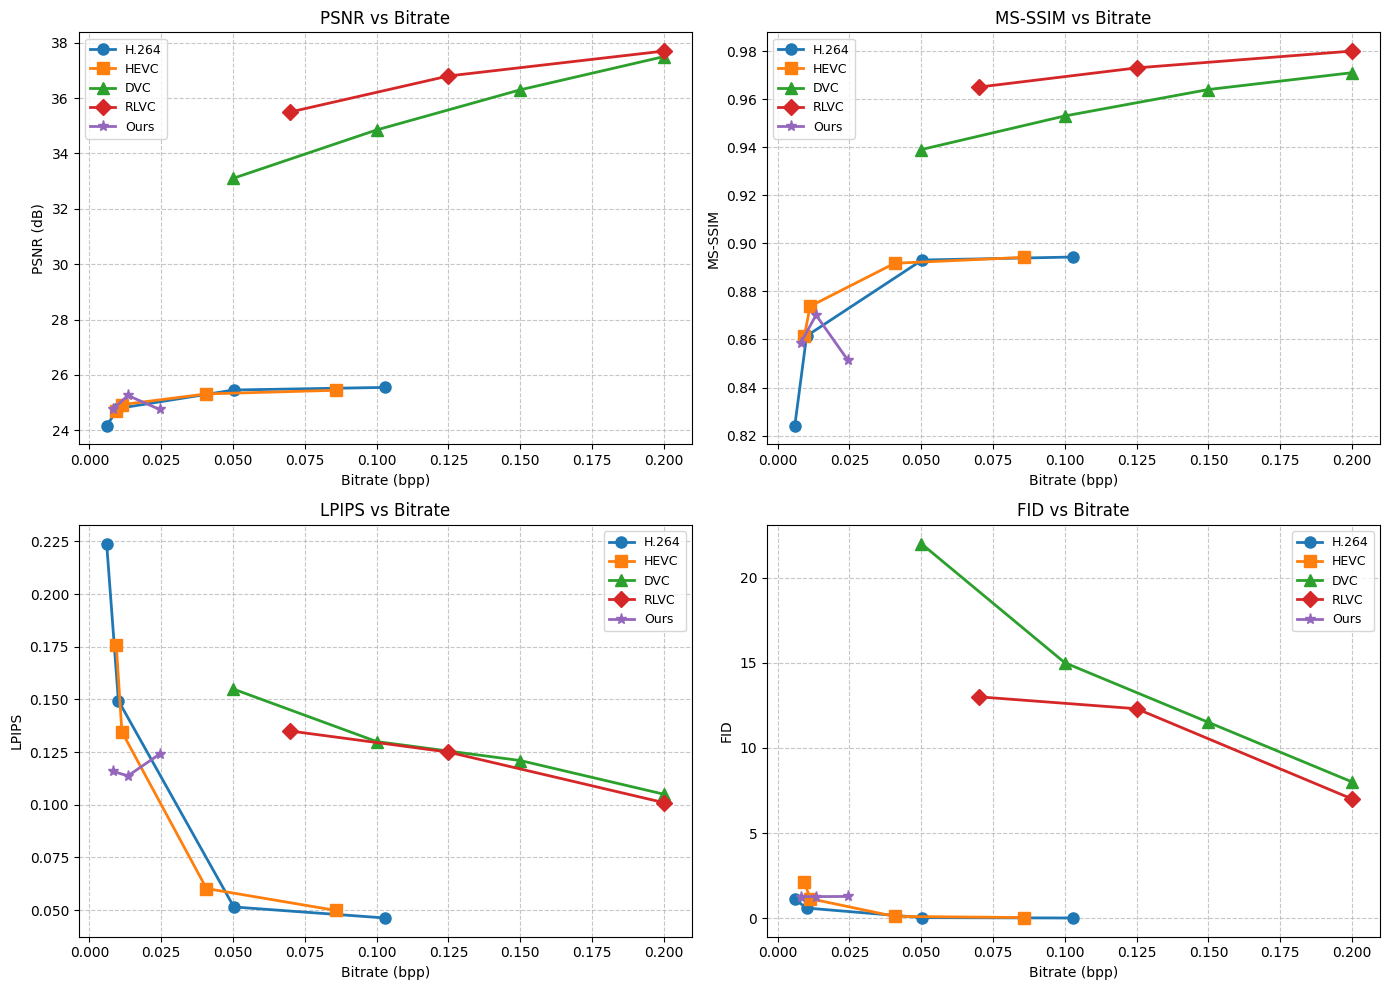

In [3]:

# Define datasets and their plotting styles
datasets = [
    {'data': h264_grouped, 'label': 'H.264', 'color': '#1f77b4', 'marker': 'o'},
    {'data': hevc_grouped, 'label': 'HEVC', 'color': '#ff7f0e', 'marker': 's'},
    {'data': DVC_uvg, 'label': 'DVC', 'color': '#2ca02c', 'marker': '^'},
    {'data': RLVC_uvg, 'label': 'RLVC', 'color': '#d62728', 'marker': 'D'},
    {'data': ours, 'label': 'Ours', 'color': '#9467bd', 'marker': '*'}
]

# Metrics to plot
metrics = ['PSNR', 'MS-SSIM', 'LPIPS', 'FID']
titles = {
    'PSNR': 'PSNR vs Bitrate',
    'MS-SSIM': 'MS-SSIM vs Bitrate',
    'LPIPS': 'LPIPS vs Bitrate',
    'FID': 'FID vs Bitrate'
}
y_labels = {
    'PSNR': 'PSNR (dB)',
    'MS-SSIM': 'MS-SSIM',
    'LPIPS': 'LPIPS',
    'FID': 'FID'
}

# Create subplots (2x2 grid for the four metrics)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten for easier iteration

# Plot each metric
for i, metric in enumerate(metrics):
    for dataset in datasets:
        # Plot each dataset
        axes[i].plot(
            dataset['data']['total_bpp'],
            dataset['data'][metric],
            marker=dataset['marker'],
            label=dataset['label'],
            color=dataset['color'],
            linewidth=2,
            markersize=8
        )
    
    # Customize plot
    axes[i].set_title(titles[metric], fontsize=12)
    axes[i].set_xlabel('Bitrate (bpp)', fontsize=10)
    axes[i].set_ylabel(y_labels[metric], fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot (optional)
# plt.savefig('codec_comparison.png', dpi=300, bbox_inches='tight')

# Show plots
plt.show()